### Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy import optimize
import subprocess

from astropy.coordinates     import SkyCoord
from lstchain.io.config      import get_standard_config
from ctapipe.io              import read_table
import tables

# Other auxiliar scripts
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux
import geometry as geom
import lstpipeline

import logging
logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

### Configuration and parameters

In [3]:
""" Source name in order to just complete the results file, and
in order to improve run organization."""
source_name = "crab"

""" Fit parameters
Chosen limits in intensity (p.e.) for applying the fit i.e. the
power law will be fitted only with the points within this range."""
limits_intensity = [316, 562]
""" For the positive scaling cases (most of them), we need to have a lower 
limit in intensity. Thi slimit is used for the subset of events that are 
scaled just to find which is the scaling value. We use a very low limit by
default 60 p.e. compared to the lower limit of the fit 316 p.e. because in 
the worst cases we will have a very non-linear scaling that will displace 
significantly the events intensities."""
limits_intensity_extended = 60

""" Power law parameters for the reference
All these parameters are taken from a common analysis of the full dataset
Where the period of end of 2022 and start 2023 is taken as reference for good 
runs. Then we take as reference the mean power law parameters in that period.
p0 is the normalization factor and p1 is the slope."""
ref_p0 =  1.74 
ref_p1 = -2.23

""" Threshold in statistics for the last subrun
The limit in number of events after cleaning that we need to consider the last
subrun has enough statistics to perform the analysis over it. Otherwise the 
values of the scaling that will be applied to this last rubrun are the same 
that are applied to the last last subrun."""
statistics_threshold = 10000

""" Parameters for the empyrical fits for Zenith Distance corrections
Are simply two 2 degree polynomials for each variable of the power law."""
p0a, p0b, p0c = -0.44751321, 3.62502037, -1.43611437
p1a, p1b, p1c = -2.89253919, 0.99443581, -0.34013068

# Standard paths for data in the IT cluster ---------
root_dl1 = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
# root_rfs = "/fefs/aswg/data/models/AllSky/20240131_allsky_v0.10.5_all_dec_base/"
root_rfs = "/fefs/aswg/data/models/AllSky/20230927_v0.10.4_crab_tuned/"
# root_mcs = "/fefs/aswg/data/mc/DL2/AllSky/20240131_allsky_v0.10.5_all_dec_base/TestingDataset/"
root_mcs = "/fefs/aswg/data/mc/DL2/AllSky/20230927_v0.10.4_crab_tuned/TestingDataset/"

# Root path of this script
root = os.getcwd() + "/"
# Path to store the configuration file we are going to use
config_file = root + "config/standard_config.json"
# Path to store objects
root_objects = root + f"objects/"
# Data main directory
root_data = root + f"../../data/cherenkov_transparency_corrections/{source_name}/"
# Sub-dl1 objects directory
root_sub_dl1 = root_objects + "sub_dl1/"
# Directory for the results of the fit of each run
root_results = root_objects + "results_fits/"
root_final_results = root_objects + "final_results_fits/"
# Configuration file for the job launching
file_job_config = root + "config/job_config_runs.txt"

def configure_lstchain():
    """Creates a file of standard configuration for the lstchain analysis. 
    It can be changed inside this function"""
    dict_config = get_standard_config()
    # We select the heuristic flatfield option in the standard configuration
    dict_config["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True
    with open(config_file, "w") as json_file:
        json.dump(dict_config, json_file)

### Reading data

In [4]:
# All the stored dictionaries that are inside the results folder
dict_files = np.sort(glob.glob(root_results + "*.pkl"))

# Storing all the run numbers and all the separate dictionaries
total_runs, dictionaries = [], []
for file in dict_files:

    # Reading the dictionaries using pickle
    with open(file, 'rb') as f:
        tmp_dict = pickle.load(f)

    total_runs.append(int(file.split("/")[-1].split("_")[2]))
    dictionaries.append(tmp_dict)

In [5]:
# # All the stored dictionaries that are inside the results folder
# dict_files = np.sort(glob.glob(root_final_results + "*.pkl"))

# # Storing all the run numbers and all the separate dictionaries
# total_runs, dictionaries = [], []
# for file in dict_files:

#     # Reading the dictionaries using pickle
#     with open(file, 'rb') as f:
#         tmp_dict = pickle.load(f)

#     total_runs.append(int(file.split("/")[-1].split("_")[2].split(".")[0]))
#     dictionaries.append(tmp_dict)

### Cleaning some of the directories, that have been filled with not tmp data

In [6]:
# Iterate over all the entries in the directory
for dir_to_delete in [root_sub_dl1]:
    for entry in os.listdir(dir_to_delete):
        entry_path = os.path.join(dir_to_delete, entry)
    
        # Check if it's a file and delete it
        if os.path.isfile(entry_path):
            os.remove(entry_path)

runs_config_file_str = np.sort(np.unique([int(s.split("_")[0]) for s in np.loadtxt(file_job_config, dtype=str)]))
runs_config_file_str = np.array([f"_job_{i}_" for i in runs_config_file_str])
tmp_files_results = glob.glob(root_results + "*")
for file in tmp_files_results:

    file_is_in_job = False
    for string in runs_config_file_str:
        if string in file:
            file_is_in_job = True
    
    # Then we delete runs not in job config
    if not file_is_in_job:
        subprocess.run(f"rm {file}", shell=True)

### Merging the dictionaries

In [5]:
# Keep only non-repeated runs
total_runs = np.unique(total_runs)

# We create a empty dict for each run we have information
dict_runs = {}
for run in total_runs:
    tmp = { 
        "run": run, "filenames": {}, "statistics": {}, "flag_error" : {},
        "scaled" :           {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "p0":                {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "delta_p0":          {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "p1":                {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "delta_p1":          {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "chi2":              {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "pvalue":            {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "light_yield":       {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "delta_light_yield": {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "scaling":           {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "delta_scaling":     {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "scaling_percent":       {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "delta_scaling_percent": {"original": {}, "upper": {}, "linear": {}, "final": {}},
        "final_scaling": {}, "final_scaling_interpolated": {}, "interpolation" : {},
    }
    dict_runs[run] = tmp

def merge_dicts(dict1, dict2):
    """
    Recursively merge two dictionaries with nested structures.

    Args:
    - dict1: First dictionary
    - dict2: Second dictionary

    Returns:
    - Merged dictionary
    """
    merged = dict1.copy()

    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            # If both values are dictionaries, recursively merge them
            merged[key] = merge_dicts(merged[key], value)
        else:
            # Otherwise, just update or add the key-value pair
            merged[key] = value
    return merged
    
# Now we fill this dicts one by one with the empty one
for d in dictionaries:
    run = d["run"]
    dict_runs[run] = merge_dicts(dict_runs[run], d)

In [7]:
# dict_runs = {}

# # Now we fill this dicts one by one with the empty one
# for d in dictionaries:
#     run = d["run"]
#     dict_runs[run] = d

### Checking statistics subrunwise

In [8]:
# We don't trust the fit for subruns with too few events or in which the fit have not suceeded
# In tose cases we will apply as the final scaling the average with the neighbors.
for run in dict_runs.keys():
    # The dictionary of one run
    dict_run = dict_runs[run]
    # Statistics object (dict)
    dict_stats = dict_run["statistics"]
    last_srun = max(dict_stats.keys())

    # We check subrun by subrun
    for srun in np.sort(list(dict_stats.keys())):
        stats = dict_stats[srun]
        flag = dict_run["flag_error"][srun]

        if stats < statistics_threshold or flag:
            logger.warning(f"\nFor run {run} subrun {srun}:\nN_events = {stats}\nFlag_error = {flag}\nSo interpolating neighbors.")

            # Search for the right neighbor until a valid one is found
            right_neighbor = srun + 1
            while right_neighbor <= last_srun and (dict_run["statistics"][right_neighbor] < statistics_threshold or dict_run["flag_error"][right_neighbor]):
                right_neighbor += 1

            # Search for the left neighbor until a valid one is found
            left_neighbor = srun - 1
            while left_neighbor >= 0 and (dict_run["statistics"][left_neighbor] < statistics_threshold or dict_run["flag_error"][left_neighbor]):
                left_neighbor -= 1

            # Case of two invalid subruns in a row
            if right_neighbor <= last_srun and left_neighbor >= 0:
                dict_runs[run]["final_scaling"][srun] = (dict_runs[run]["final_scaling"][left_neighbor] + dict_runs[run]["final_scaling"][right_neighbor]) / 2
                dict_runs[run]["delta_final_scaling"][srun] = (dict_runs[run]["delta_final_scaling"][left_neighbor] + dict_runs[run]["delta_final_scaling"][right_neighbor]) / 2
            elif right_neighbor <= last_srun:
                dict_runs[run]["final_scaling"][srun] = dict_runs[run]["final_scaling"][right_neighbor]
                dict_runs[run]["delta_final_scaling"][srun] = dict_runs[run]["delta_final_scaling"][right_neighbor]
            elif left_neighbor >= 0:
                dict_runs[run]["final_scaling"][srun] = dict_runs[run]["final_scaling"][left_neighbor]
                dict_runs[run]["delta_final_scaling"][srun] = dict_runs[run]["delta_final_scaling"][left_neighbor]
            else:
                logger.warning(f"No valid neighbors found for run {run} subrun {srun}. Unable to interpolate.")



For run 2914 subrun 114:
N_events = 1500
Flag_error = False
So interpolating neighbors.

For run 2930 subrun 157:
N_events = 3885
Flag_error = True
So interpolating neighbors.

For run 2930 subrun 158:
N_events = 5158
Flag_error = False
So interpolating neighbors.

For run 2930 subrun 159:
N_events = 6543
Flag_error = True
So interpolating neighbors.

For run 2930 subrun 160:
N_events = 8544
Flag_error = False
So interpolating neighbors.

For run 2932 subrun 65:
N_events = 3731
Flag_error = True
So interpolating neighbors.

For run 2932 subrun 67:
N_events = 8073
Flag_error = False
So interpolating neighbors.

For run 2932 subrun 68:
N_events = 3801
Flag_error = True
So interpolating neighbors.

For run 2932 subrun 70:
N_events = 5963
Flag_error = True
So interpolating neighbors.

For run 2932 subrun 71:
N_events = 4606
Flag_error = True
So interpolating neighbors.

For run 2932 subrun 75:
N_events = 4362
Flag_error = True
So interpolating neighbors.

For run 2932 subrun 76:
N_events 

# Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [9]:
%%time
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
}

# We create a empty dictionary to store all the information needed inside
dict_dchecks = {}
for run in total_runs:
    dict_dchecks[run] = {
        "run_num" : run,
    }

dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1)
dict_dchecks = lstpipeline.add_dl1_paths_to_dict(dict_dchecks, root_dl1, dchecking=True)


Adding dl1  data to dictionary (Run 2914)...

Adding dl1  data to dictionary (Run 2929)...

Adding dl1  data to dictionary (Run 2930)...

Adding dl1  data to dictionary (Run 2931)...

Adding dl1  data to dictionary (Run 2932)...

Adding dl1  data to dictionary (Run 2933)...

Adding dl1  data to dictionary (Run 2934)...

Adding dl1  data to dictionary (Run 2949)...

Adding dl1  data to dictionary (Run 2950)...

Adding dl1  data to dictionary (Run 2967)...

Adding dl1  data to dictionary (Run 2968)...

Adding dl1  data to dictionary (Run 2969)...

Adding dl1  data to dictionary (Run 2970)...

Adding dl1  data to dictionary (Run 2971)...

Adding dl1  data to dictionary (Run 2972)...

Adding dl1  data to dictionary (Run 2973)...

Adding dl1  data to dictionary (Run 2974)...

Adding dl1  data to dictionary (Run 2975)...

Adding dl1  data to dictionary (Run 2976)...

Adding dl1  data to dictionary (Run 2977)...

Adding dl1  data to dictionary (Run 2988)...

Adding dl1  data to dictionary (R

CPU times: user 49.1 s, sys: 6.14 s, total: 55.2 s
Wall time: 1min 3s


#### Then we read the observations information and also the selected nodes for MC and RFs and we add it to the DICT

In [10]:
%%time
for ir, run_number in enumerate(total_runs):
    logger.info(f"Reading datacheck from {run_number} -{ir / len(total_runs) * 100:.1f}%")
    dcheck_zd, dcheck_az = [], []
    dcheck_tstart, dcheck_telapsed = [], []
    
    for srun in range(len(dict_dchecks[run_number]["dchecks"]["srunwise"])):
        tab_dcheck_srun = read_table(dict_dchecks[run_number]["dchecks"]["srunwise"][srun], "/dl1datacheck/cosmics")
        
        # reading the variables
        dcheck_zd.append(90 - np.rad2deg(tab_dcheck_srun["mean_alt_tel"]))
        dcheck_az.append(np.rad2deg(tab_dcheck_srun["mean_az_tel"]))
        
        dcheck_tstart.append(tab_dcheck_srun["dragon_time"])
        dcheck_telapsed.append(tab_dcheck_srun["elapsed_time"])
    
    dcheck_zd = np.array(dcheck_zd)
    dcheck_az = np.array(dcheck_az)
    dcheck_tstart = np.array(dcheck_tstart)
    dcheck_telapsed = np.array(dcheck_telapsed)
    
    dict_dchecks[run_number]["time"] = {
        "tstart"   : dcheck_tstart[0],        # datetime object
        "telapsed" : np.sum(dcheck_telapsed), # s
        "srunwise" : {
            "telapsed" : dcheck_telapsed,     # s      
        },
    }
    dict_dchecks[run_number]["pointing"] = {
        "zd" : np.mean(dcheck_zd), # deg
        "az" : np.mean(dcheck_az), # deg
        "srunwise" : {
            "zd" : dcheck_zd, # deg
            "az" : dcheck_az, # deg
        },
    }

# then we also select the RFs and MC files looking at the nodes available
dict_dchecks, dict_nodes = lstpipeline.add_mc_and_rfs_nodes(dict_dchecks, root_rfs, root_mcs, dict_source)

Reading datacheck from 2914 -0.0%
Reading datacheck from 2929 -1.7%
Reading datacheck from 2930 -3.3%
Reading datacheck from 2931 -5.0%
Reading datacheck from 2932 -6.7%
Reading datacheck from 2933 -8.3%
Reading datacheck from 2934 -10.0%
Reading datacheck from 2949 -11.7%
Reading datacheck from 2950 -13.3%
Reading datacheck from 2967 -15.0%
Reading datacheck from 2968 -16.7%
Reading datacheck from 2969 -18.3%
Reading datacheck from 2970 -20.0%
Reading datacheck from 2971 -21.7%
Reading datacheck from 2972 -23.3%
Reading datacheck from 2973 -25.0%
Reading datacheck from 2974 -26.7%
Reading datacheck from 2975 -28.3%
Reading datacheck from 2976 -30.0%
Reading datacheck from 2977 -31.7%
Reading datacheck from 2988 -33.3%
Reading datacheck from 2989 -35.0%
Reading datacheck from 2990 -36.7%
Reading datacheck from 2991 -38.3%
Reading datacheck from 2992 -40.0%
Reading datacheck from 3004 -41.7%
Reading datacheck from 3005 -43.3%
Reading datacheck from 3006 -45.0%
Reading datacheck from 300

CPU times: user 3min 45s, sys: 13.6 s, total: 3min 59s
Wall time: 6min 6s


### Then we interpolate the lineal scalings with a linear behaviour trough the run

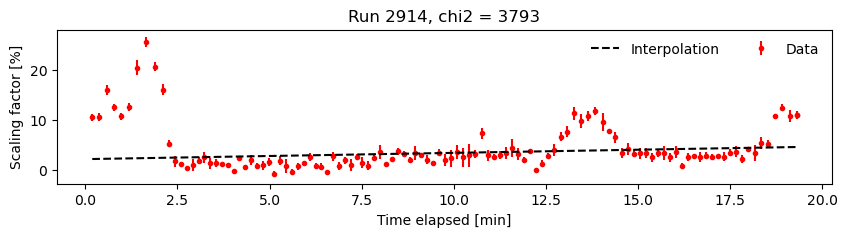

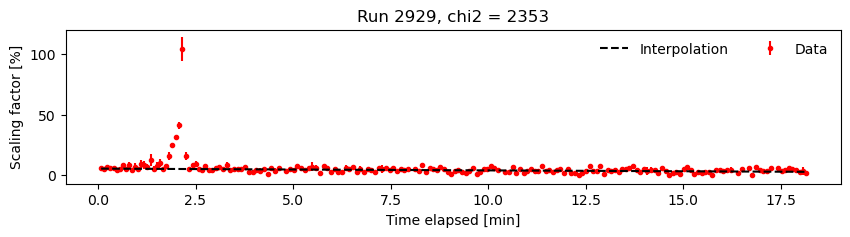

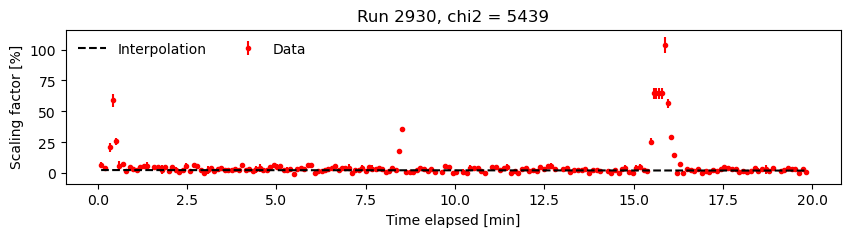

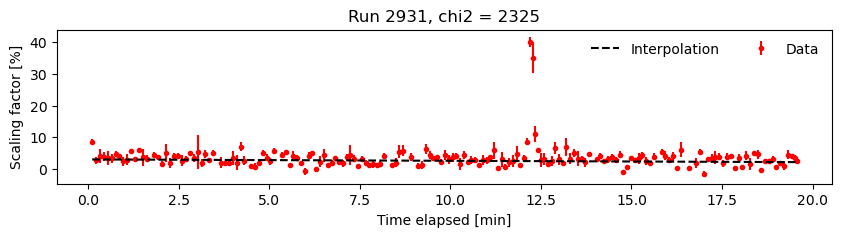

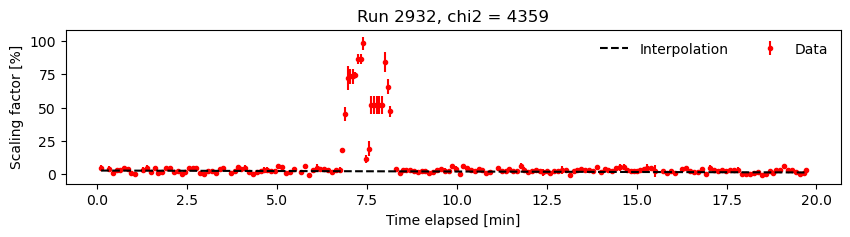

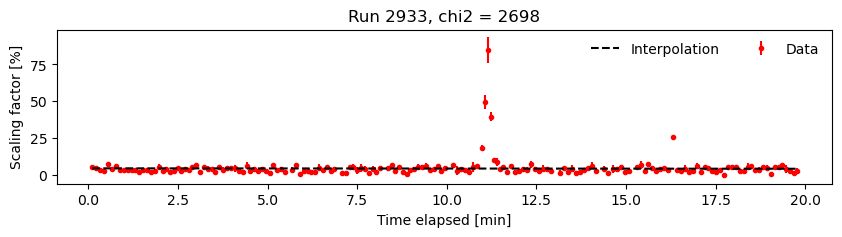

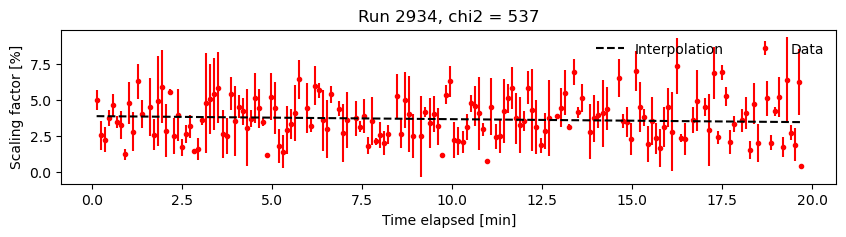

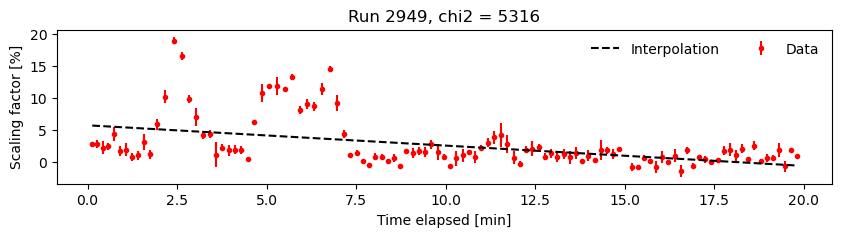

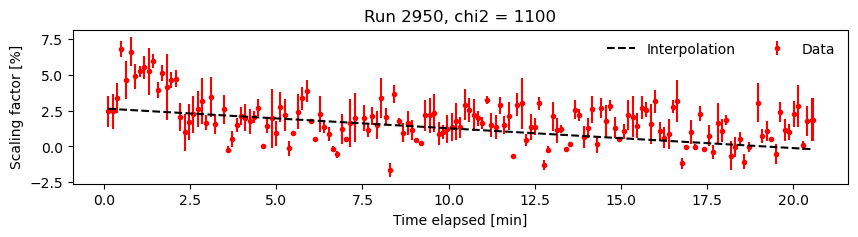

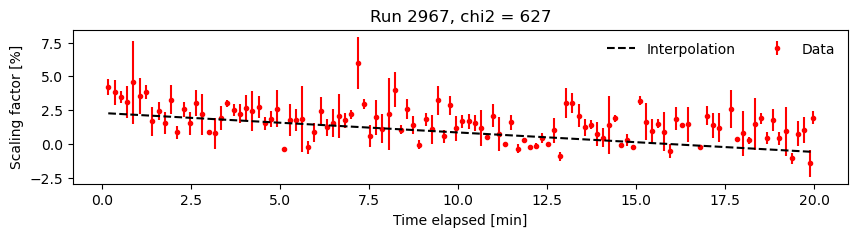

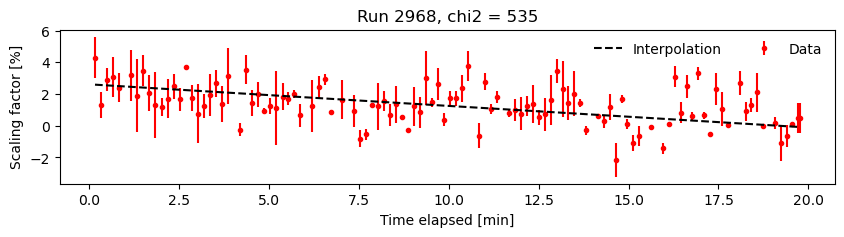

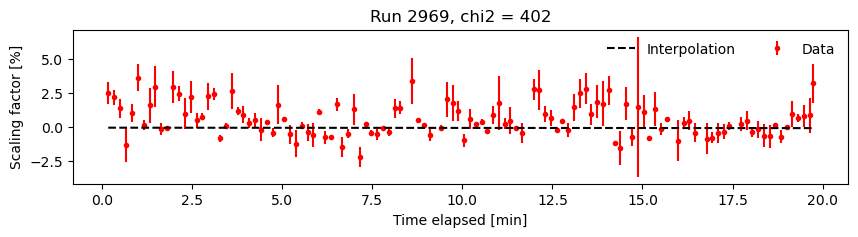

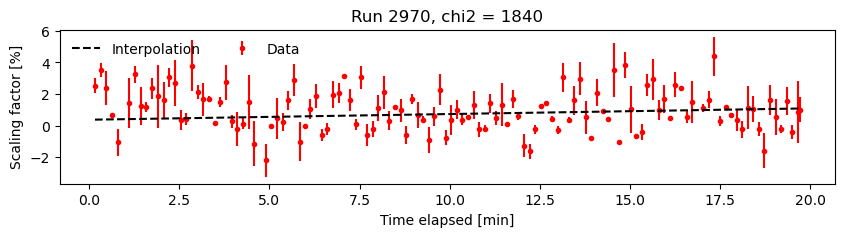

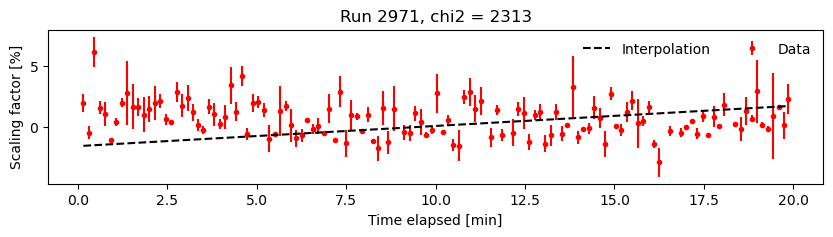

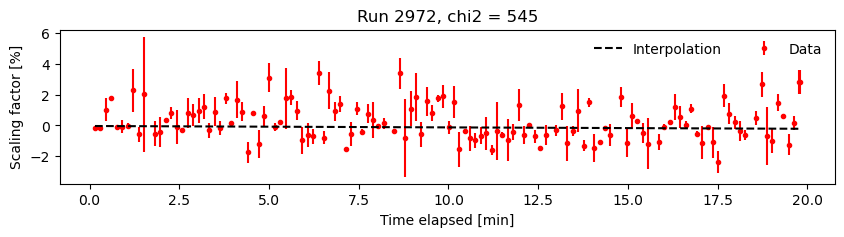

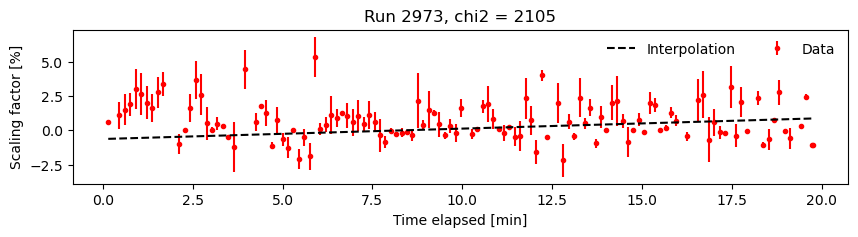

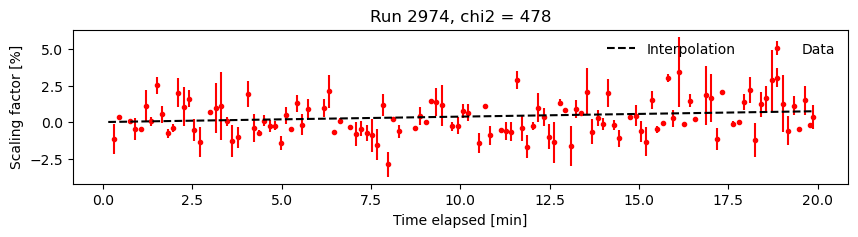

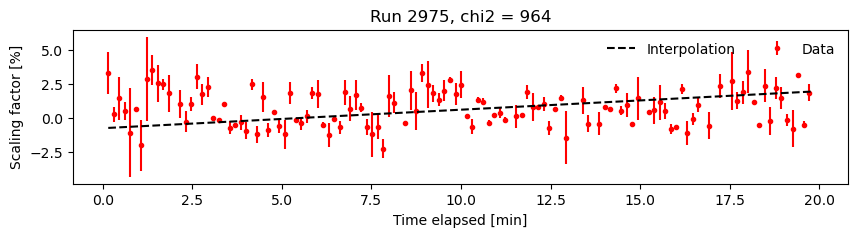

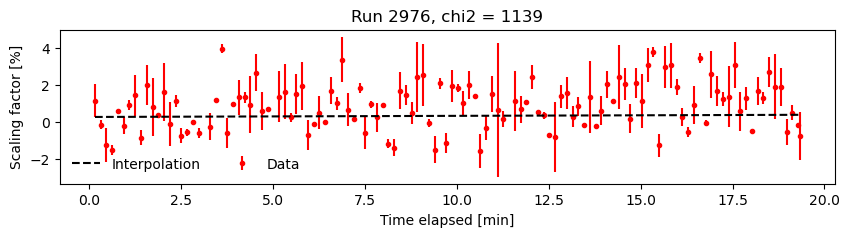

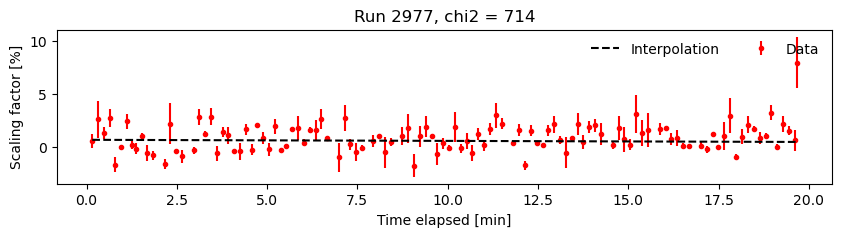

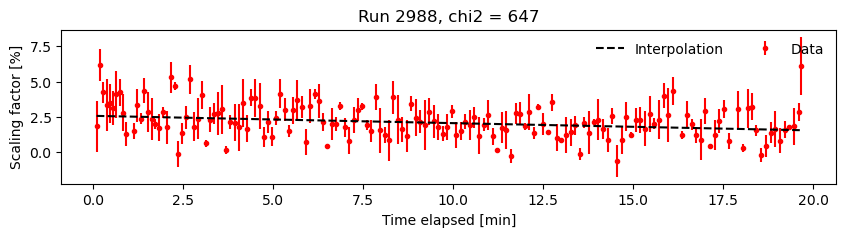

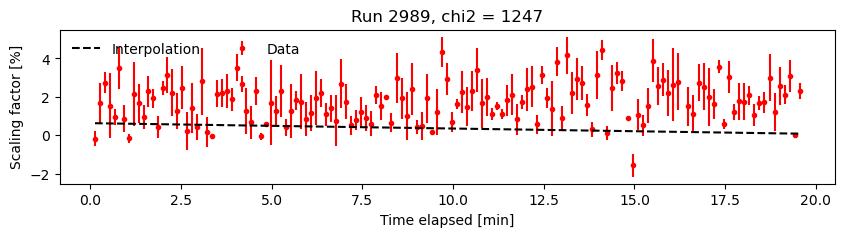

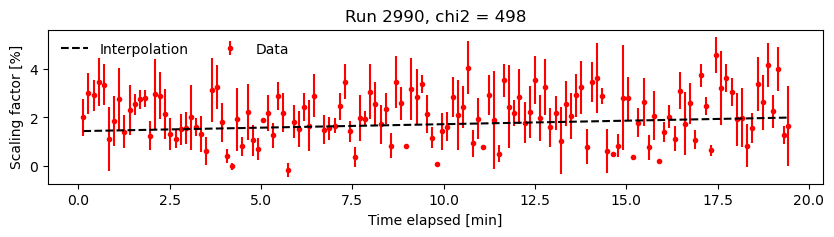

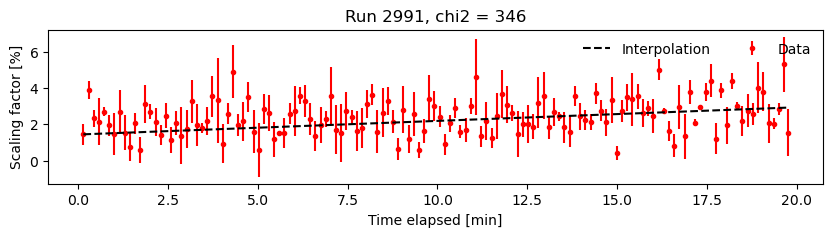

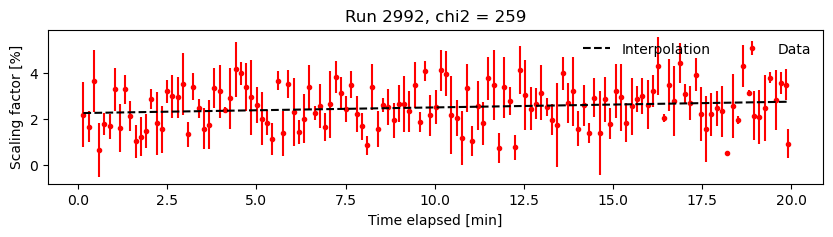

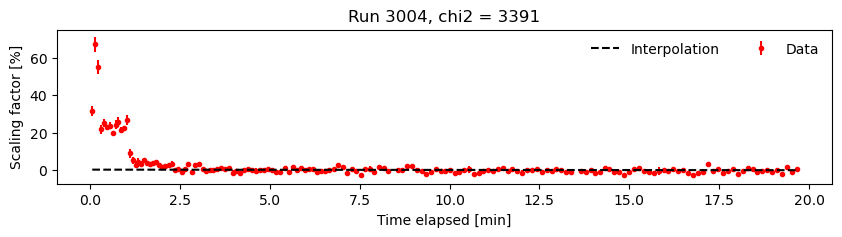

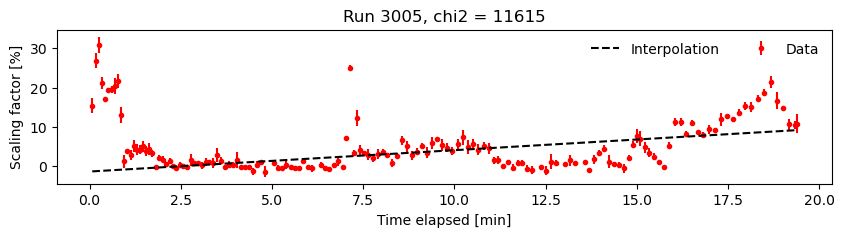

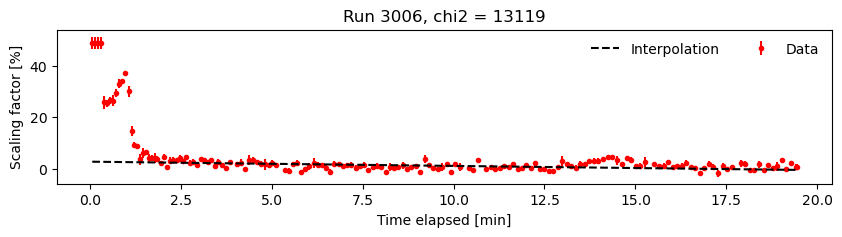

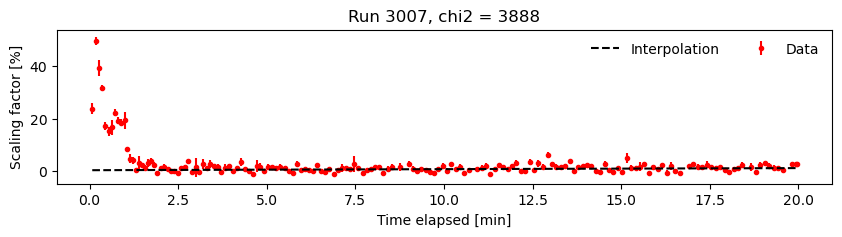

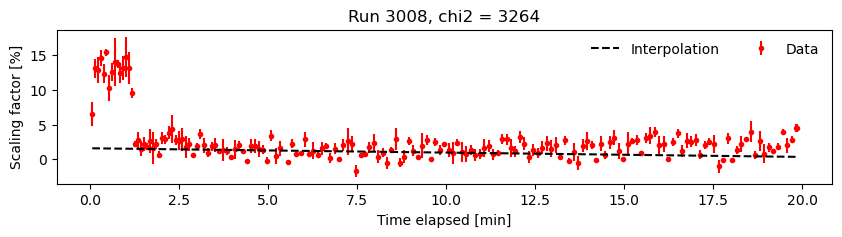

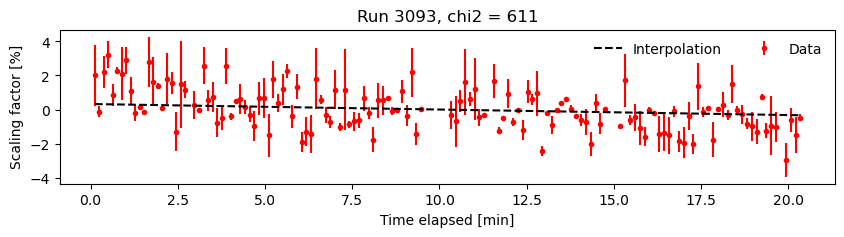

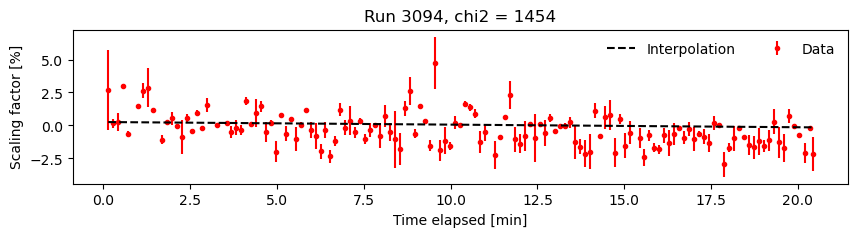

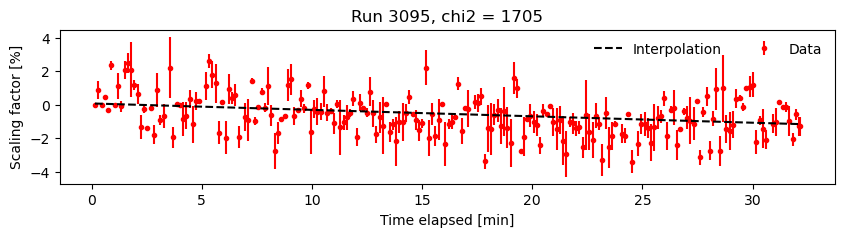

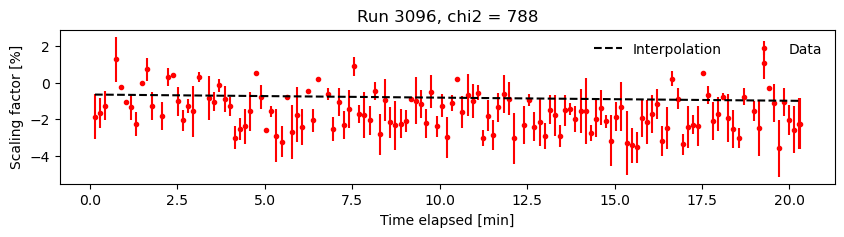

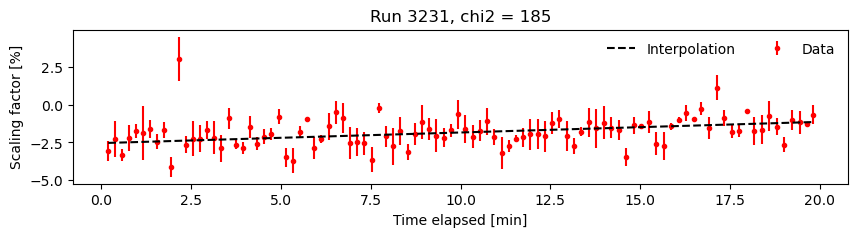

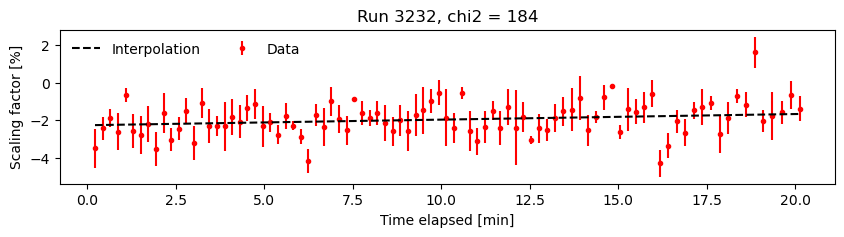

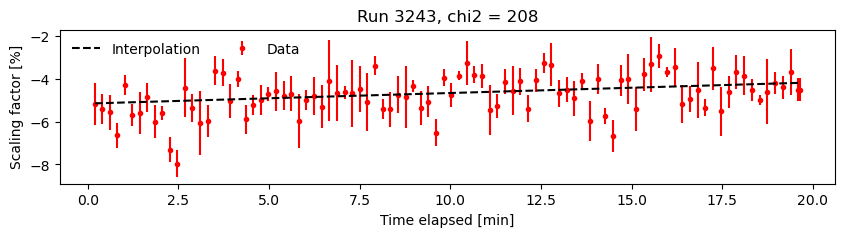

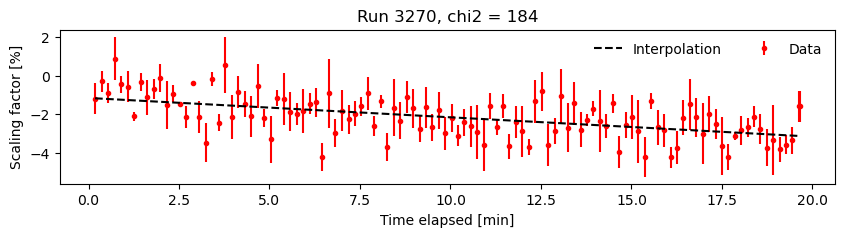

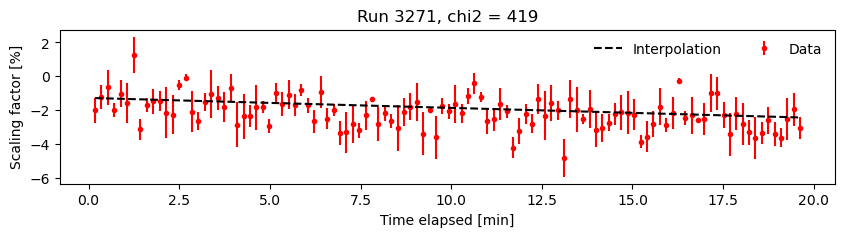

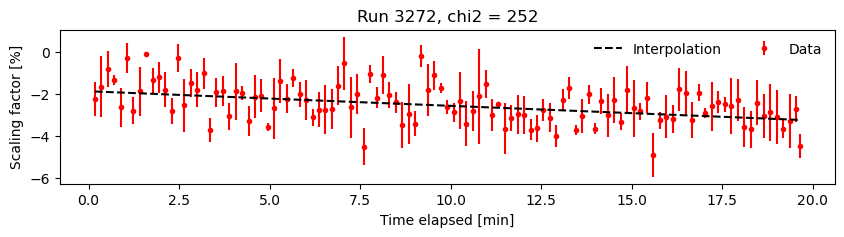

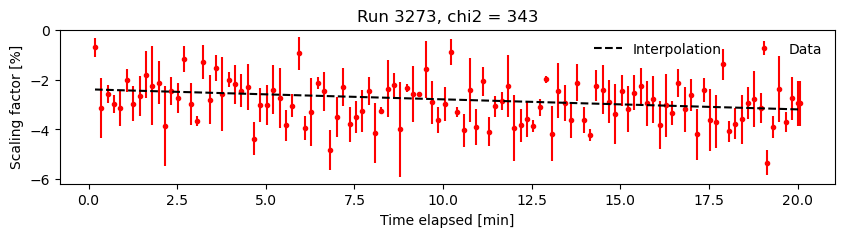

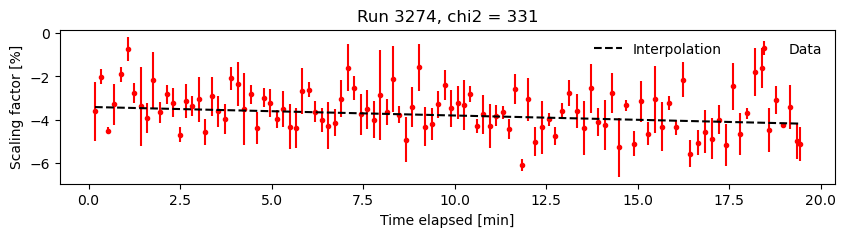

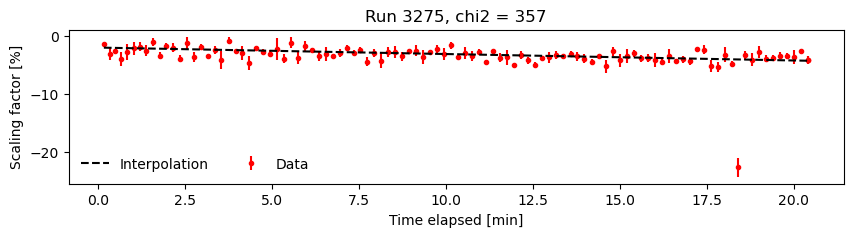

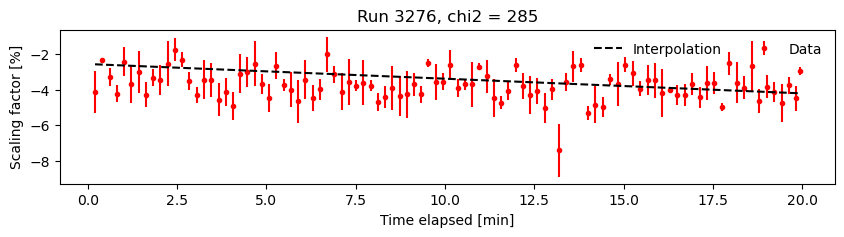

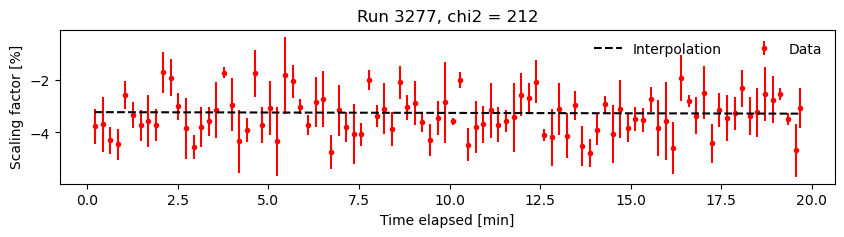

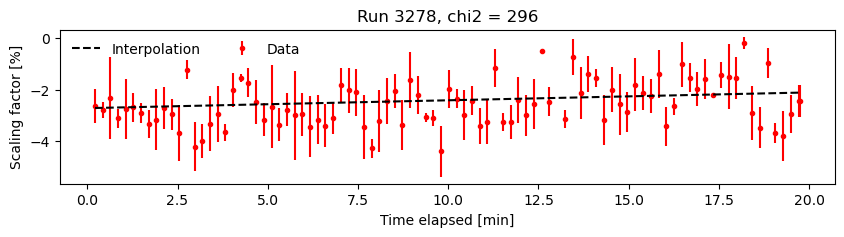

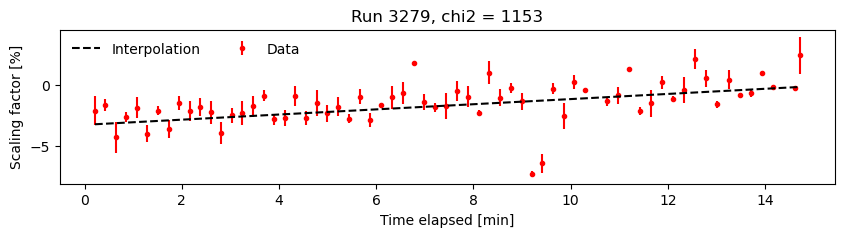

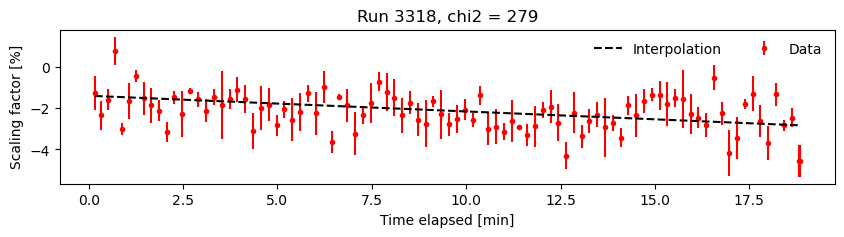

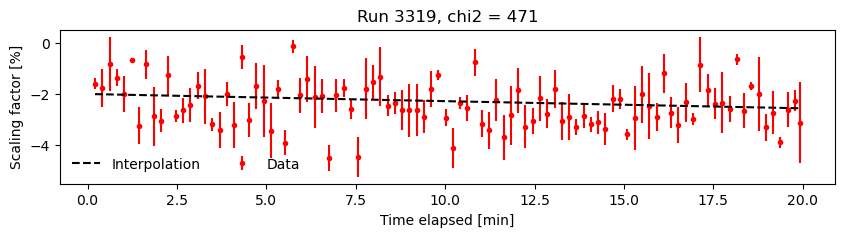

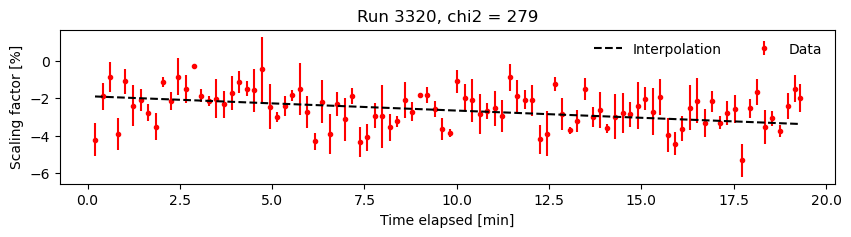

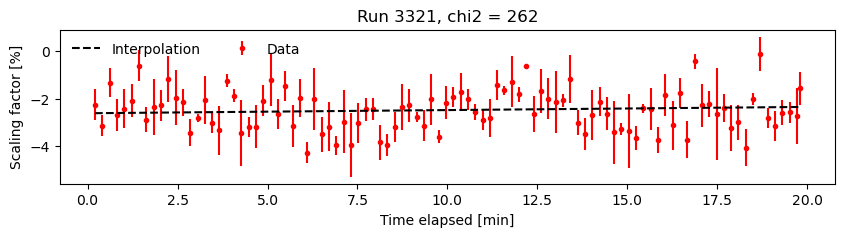

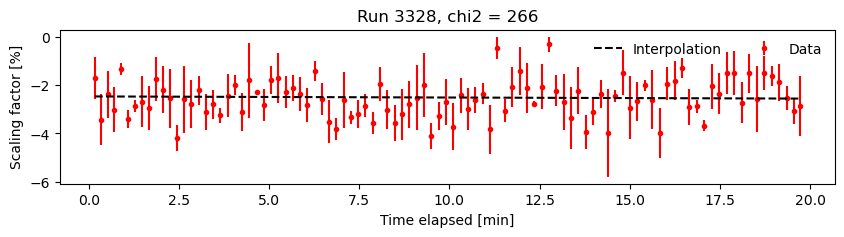

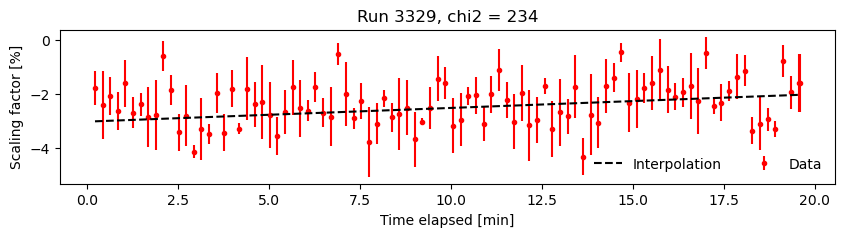

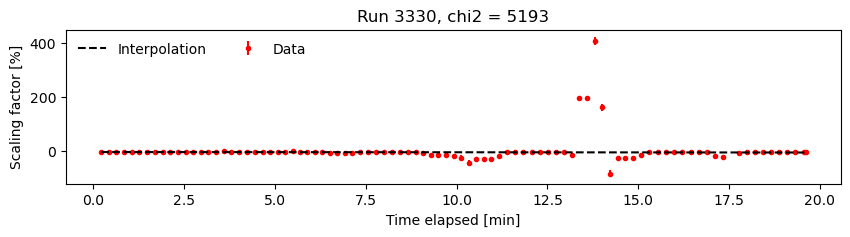

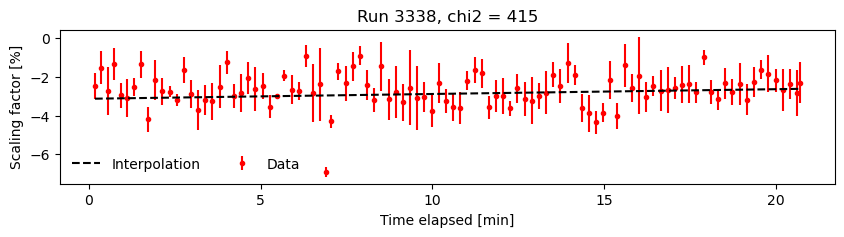

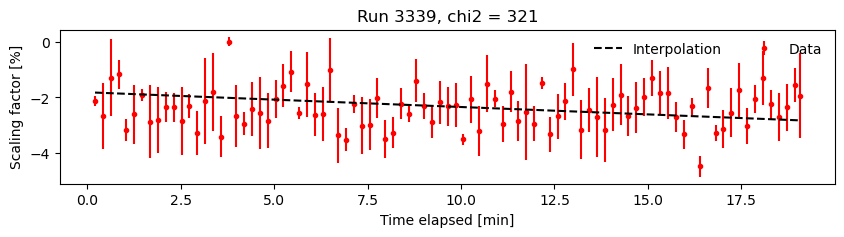

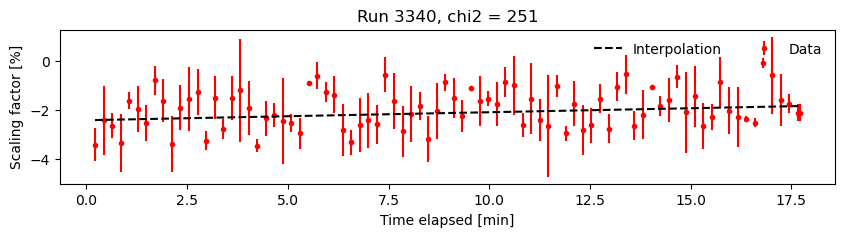

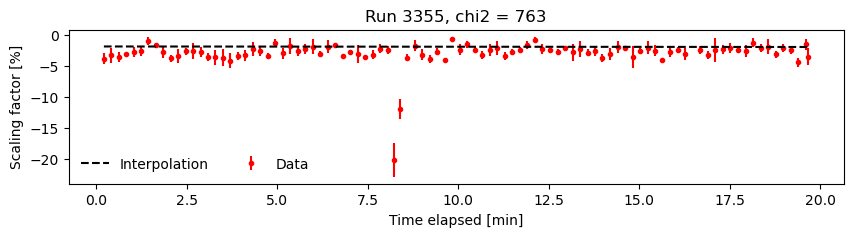

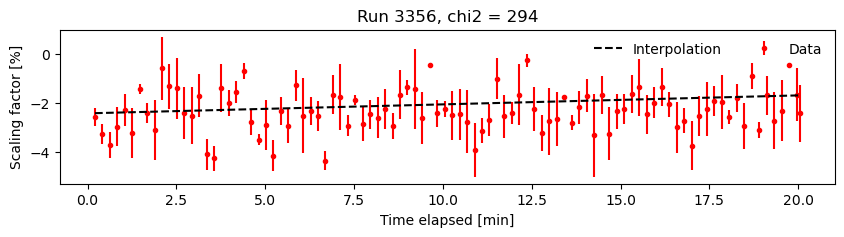

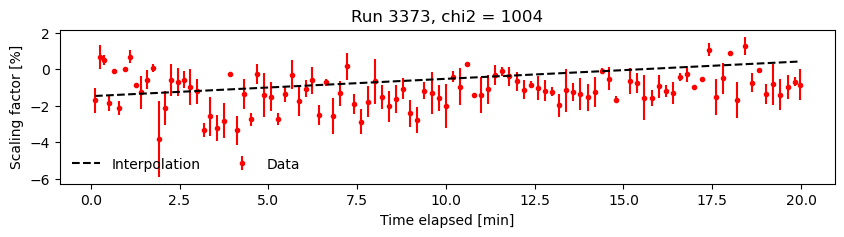

In [32]:
for ir, run_number in enumerate(total_runs):

    # logger.info(f"Interpolating... {run_number} -{ir / len(total_runs) * 100:.1f}%")
    dict_results = dict_runs[run_number]

    x_fit = np.cumsum(dict_dchecks[run_number]["time"]["srunwise"]["telapsed"])
    y_fit = np.array([dict_results["final_scaling"][srun] for srun in np.sort(list(dict_results["final_scaling"].keys()))])
    yerr_fit = np.array([dict_results["delta_final_scaling"][srun] for srun in np.sort(list(dict_results["final_scaling"].keys()))])
    
    nan_mask = ~(np.isnan(x_fit) | np.isnan(y_fit) | np.isnan(yerr_fit))
    x_fit_masked = x_fit[nan_mask]
    y_fit_masked = y_fit[nan_mask]
    yerr_fit_masked = yerr_fit[nan_mask]
    
    # Performing the fit
    params, pcov, info, _, _ = curve_fit(
        f     = geom.straight_line,
        xdata = x_fit_masked,
        ydata = y_fit_masked,
        sigma = yerr_fit_masked,
        p0    = [1, 0],
        full_output = True,
    )
        
    intercept       = params[0]
    slope           = params[1]
    delta_intercept = np.sqrt(pcov[0, 0])
    delta_slope     = np.sqrt(pcov[1, 1])
    _chi2           = np.sum(info["fvec"] ** 2)
    pvalue          = 1 - chi2.cdf(_chi2, len(x_fit_masked))
    
    dict_results["interpolation"] = {
        "chi2" : _chi2,      
        "p_value" : pvalue,         
        "slope": slope,      
        "delta_slope" : delta_slope,     
        "intercept" : intercept, 
        "delta_intercept" : delta_intercept,
    }
    
    #############################################
    #############################################
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    
    ax.plot(x_fit/60, ((intercept + x_fit * slope) - 1) * 100, color="k", ls="--", zorder=10, label="Interpolation")
    
    # ax.plot(x_fit/60, (y_fit - 1) * 100, 'r', label='Data')
    ax.errorbar(x_fit/60, (y_fit - 1) * 100, yerr=yerr_fit * 100, color='r', ls="", marker=".",  label='Data', )
    
    ax.set_xlabel("Time elapsed [min]")
    ax.set_ylabel("Scaling factor [%]")
    ax.set_title(f"Run {run_number}, chi2 = {_chi2:.0f}")
    ax.legend(ncols=2, frameon=False)
    
    plt.show()
    #############################################
    #############################################
    
    # Setting a interpolated scaling factor
    for srun in dict_results["final_scaling"].keys():
        
        scaling_interpolated = intercept + slope * x_fit[srun]
        
        dict_results["final_scaling_interpolated"][srun] = scaling_interpolated
        dict_results["scaled"]["final"][srun]            = scaling_interpolated

    dict_fname = root_final_results + f"results_job_{run_number}.pkl"
    
    # Saving the object
    # with open(dict_fname, 'wb') as f:
    #     pickle.dump(dict_results, f, pickle.HIGHEST_PROTOCOL)

### Then we can clean the temporal result directory

In [10]:
for file in glob.glob(root_results + "*"):
    command = f"rm {file}"
    subprocess.run(command, shell=True)

#### Added the error in the files that did not have it

In [11]:
# for f in glob.glob(root_final_results + "*")[:]:
#     with open(f, 'rb') as ff:
#         _dict_results_ = pickle.load(ff)
#     print(f, "modification")
    
#     srun_numbers = np.sort(list(_dict_results_["statistics"].keys()))
#     _dict_results_["delta_final_scaling"] = {}
    
#     for srun in srun_numbers:
#         # Now putting all together, upper and half
#         points_scaling           = np.array([_dict_results_["scaled"][key][srun]            for key in ["original", "linear", "upper"]])
#         points_light_yield       = np.array([_dict_results_["light_yield"][key][srun]       for key in ["original", "linear", "upper"]])
#         points_delta_light_yield = np.array([_dict_results_["delta_light_yield"][key][srun] for key in ["original", "linear", "upper"]])     
            
#         srun_a, srun_b, srun_c, srun_delta_a, srun_delta_b, srun_delta_c = geom.parabola_3points(
#             *points_scaling, *points_light_yield, *points_delta_light_yield
#         )
        
#         range_avg_point = np.mean(points_scaling)
#         x0, delta_x0 = geom.get_roots_pol2(
#             range_avg_point, 1,*points_scaling, *points_light_yield, *points_delta_light_yield
#         )

#         final_scale_factor = x0
#         delta_final_scale_factor = delta_x0

        
#         # ############################################
#         # fig, ax = plt.subplots(1, 1, figsize=(5, 3))
#         # ax.errorbar(points_scaling, points_light_yield, yerr=points_delta_light_yield,
#         #             marker=".", color="k", label="Points", zorder=10, ls="")
#         # size_points = max(points_scaling) - min(points_scaling)
#         # sample_scaling = np.linspace(min(points_scaling) - 0.1 * size_points, max(points_scaling) + 0.1 * size_points, 100)
#         # ax.plot(sample_scaling, geom.pol2(sample_scaling, srun_a, srun_b, srun_c), 
#         #         color="crimson", ls="-", label="Polynomial fit", zorder=5)
#         # ax.axvline(x0, color="k", ls="--", label=f"Final scaling = {final_scale_factor:.2f}")
#         # ax.axvspan(x0 - delta_x0, x0 + delta_x0, color="k", alpha=0.2, ls="")
#         # ax.axhline(1, color="k", ls=":", label="Reference")
#         # ax.set_xlabel("Scaling")
#         # ax.set_ylabel("Light yield")
#         # ax.legend(frameon=False)
#         # ax.set_title(f"Subrun {srun}")
#         # # plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
#         # plt.show()
#         # ############################################
            
#         _dict_results_["final_scaling"][srun] = final_scale_factor
#         _dict_results_["delta_final_scaling"][srun] = delta_final_scale_factor

#     # Saving the object
#     with open(f, 'wb') as ff:
#         pickle.dump(_dict_results_, ff, pickle.HIGHEST_PROTOCOL)